# Explore

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re
from sklearn.cluster import KMeans
import numpy as np

from wordcloud import WordCloud

In [8]:
#Acquire prepped data

df = pd.read_csv('cleaned_readmes.csv', index_col = 0)
df.head()

,repo,language,content
0,microsoft/react-native-windows,C++,h1 aligncenter react native window h1 p alignc...
1,microsoft/fast,TypeScript,fastbannergithub914pnghttpsstaticfastdesignass...
2,microsoft/Application-Insights-Workbooks,JSON,azure monitor workbook template build statusht...
3,microsoft/gctoolkit,Java,microsoft gctoolkit gctoolkit set library anal...
4,microsoft/winget-cli-restsource,C#,welcome wingetclirestsource repository buildin...


In [9]:
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'percent']
languages

,n,percent
TypeScript,354,0.257267
C#,242,0.175872
Python,176,0.127907
C++,112,0.081395
JavaScript,92,0.066860
PowerShell,76,0.055233
Jupyter Notebook,45,0.032703
C,44,0.031977
HTML,37,0.026890
Java,27,0.019622


In [10]:
df.head()

,repo,language,content
0,microsoft/react-native-windows,C++,h1 aligncenter react native window h1 p alignc...
1,microsoft/fast,TypeScript,fastbannergithub914pnghttpsstaticfastdesignass...
2,microsoft/Application-Insights-Workbooks,JSON,azure monitor workbook template build statusht...
3,microsoft/gctoolkit,Java,microsoft gctoolkit gctoolkit set library anal...
4,microsoft/winget-cli-restsource,C#,welcome wingetclirestsource repository buildin...


In [11]:
df['is_TypeScript'] = df.language == 'TypeScript'
df.head()

,repo,language,content,is_TypeScript
0,microsoft/react-native-windows,C++,h1 aligncenter react native window h1 p alignc...,False
1,microsoft/fast,TypeScript,fastbannergithub914pnghttpsstaticfastdesignass...,True
2,microsoft/Application-Insights-Workbooks,JSON,azure monitor workbook template build statusht...,False
3,microsoft/gctoolkit,Java,microsoft gctoolkit gctoolkit set library anal...,False
4,microsoft/winget-cli-restsource,C#,welcome wingetclirestsource repository buildin...,False


In [23]:
TS_words = ' '.join(df[df.language == 'TypeScript'].content.astype('str')).split()

In [24]:
NTS_words = ' '.join(df[df.language != 'TypeScript'].content.astype('str')).split()
all_words = ' '.join(df.content.astype('str')).split()

In [38]:
TS_freq = pd.Series(TS_words).value_counts()
NTS_freq = pd.Series(NTS_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

all_freq.head()

code         5129
use          5058
project      4982
microsoft    3954
file         3836
dtype: int64

In [39]:
word_counts = (pd.concat([all_freq, TS_freq, NTS_freq], axis=1, sort=True)
                .set_axis(['all', 'TS', 'NTS'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,TS,NTS
',75,18,57
'',189,56,133
''',6,0,6
''1''',1,0,1
''105,1,0,1


In [40]:
# word_counts = (pd.concat([all_freq, TS_freq, NTS_freq], axis=1, sort=True)
#                 .set_axis(['all', 'TS', 'NTS'], axis=1)
#                 .fillna(0))

#word_counts.head(100)

In [41]:
df.isna().sum()

repo             0
language         0
content          6
is_TypeScript    0
dtype: int64

Text(0.5, 1.0, 'Proportion of Non-TypeScript vs TypeScript for the 20 most common words')

<Figure size 864x576 with 0 Axes>

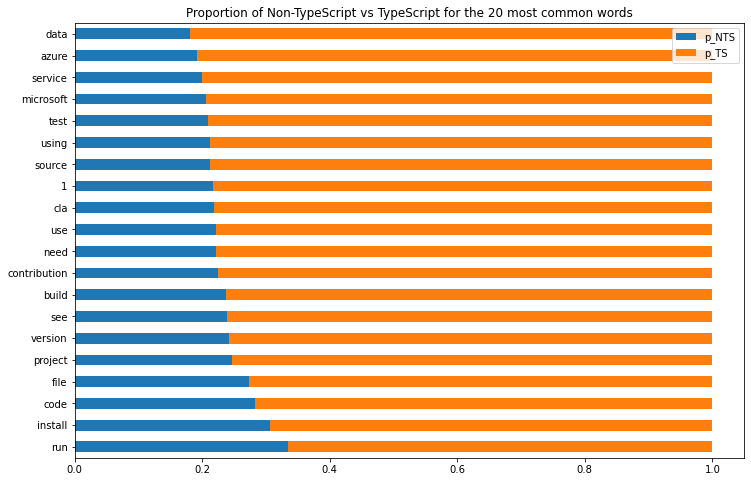

In [52]:
plt.figure(figsize = (12, 8))

# figure out the percentage
(word_counts
 .assign(p_TS=word_counts.NTS / word_counts['all'],
         p_NTS=word_counts.TS / word_counts['all'])
 .sort_values(by='all')
 [['p_NTS', 'p_TS']]
 .tail(20)
 .sort_values('p_TS')
 .plot.barh(stacked=True,figsize = (12, 8)))



plt.title('Proportion of Non-TypeScript vs TypeScript for the 20 most common words')

In [47]:
(word_counts
 [(word_counts.NTS > 10) & (word_counts.TS > 10)]
 .assign(ratio=lambda df: df.NTS / (df.TS + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,TS,NTS,ratio
yarn,340,286,54,0.188805
eslint,132,110,22,0.199982
webpack,83,69,14,0.202869
board,64,53,11,0.207508
chart,255,207,48,0.231873
learning,613,32,581,18.150578
powershell,652,27,625,23.139578
2019,267,11,256,23.251589
net,544,12,532,44.296420
training,566,12,554,46.128226


Text(0.5, 1.0, 'Proportion of TypeScript vs Non-TypeScript for the 20 most common words')

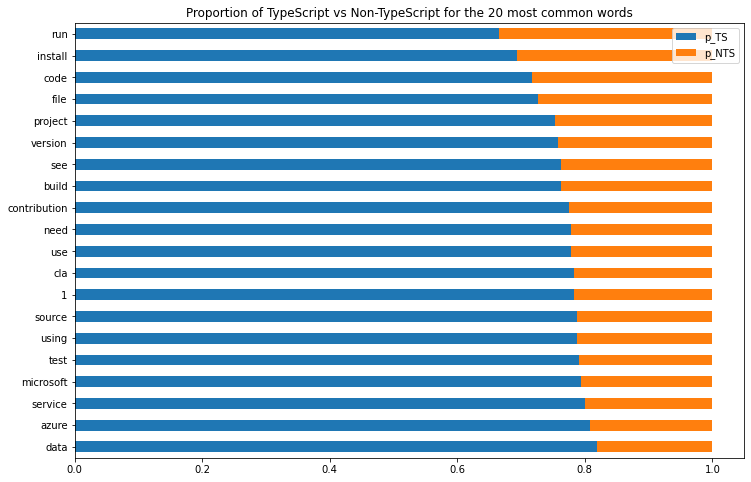

In [51]:
# figure out the percentage
(word_counts
 .assign(p_NTS=word_counts.TS / word_counts['all'],
         p_TS=word_counts.NTS / word_counts['all'])
 .sort_values(by='all')
 [['p_TS', 'p_NTS']]
 .tail(20)
 .sort_values('p_NTS')
 .plot.barh(stacked=True,figsize = (12, 8)))



plt.title('Proportion of TypeScript vs Non-TypeScript for the 20 most common words')

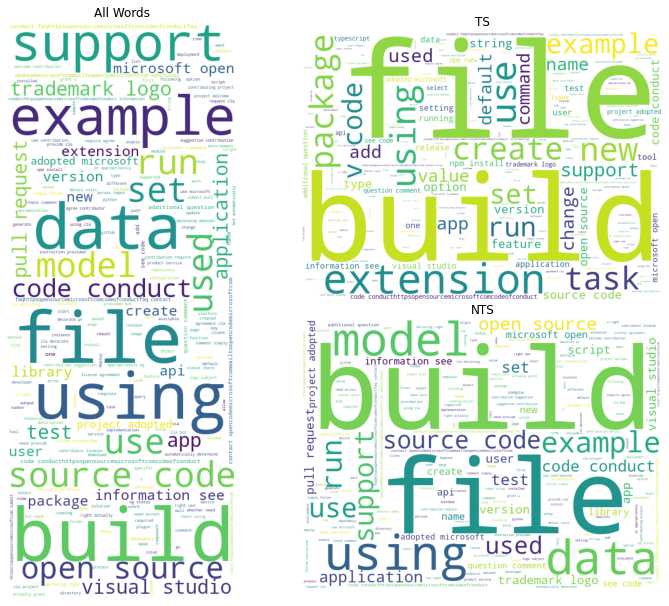

In [53]:
#Create Word Clouds 

all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
TS_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(TS_words))
NTS_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(NTS_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(TS_cloud)
axs[2].imshow(NTS_cloud)

axs[0].set_title('All Words')
axs[1].set_title('TS')
axs[2].set_title('NTS')

for ax in axs: ax.axis('off')

In [54]:
#Bi-grams

top_20_TS_bigrams = (pd.Series(nltk.ngrams(TS_words, 2))
                      .value_counts()
                      .head(20))

top_20_TS_bigrams.head()

(v, code)          321
(source, code)     271
(code, conduct)    263
(open, source)     258
(npm, install)     252
dtype: int64

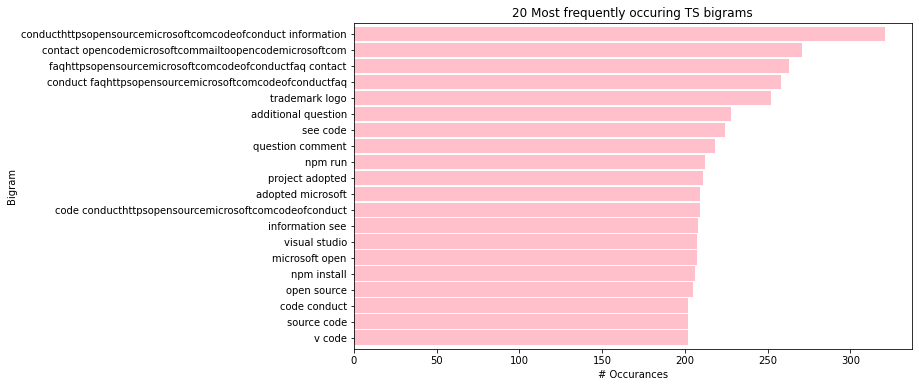

In [55]:
top_20_TS_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring TS bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_TS_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

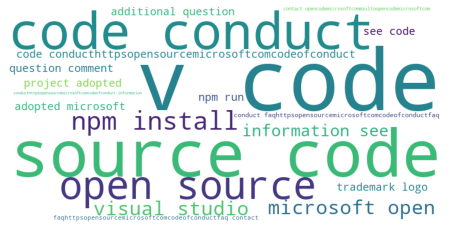

In [56]:
#Bigram Word Clouds

# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_TS_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()